In [ ]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import math
import deepxde as dde 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

2023-10-07 07:43:26.401531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-07 07:43:26.401577: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-07 07:43:26.401608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-07 07:43:26.411106: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



# Solving ODE with Neural Networks

In [3]:
geom = dde.geometry.TimeDomain(0, 2)

In [4]:
geom.on_initial([0]), geom.on_initial(2)

(array([ True]), array([False]))

In [5]:
np.isclose([0], 0)

array([ True])

In [6]:
t = geom.uniform_points(5)
t.shape, t

((5, 1),
 array([[0. ],
        [0.5],
        [1. ],
        [1.5],
        [2. ]], dtype=float32))

In [7]:
#  (t, Geometry.on_initial(t)) -> True/False.
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

ic = dde.IC(geom, lambda t: 1, boundary)

In [8]:
def ode_system(t, u):
    pi = tf.constant(math.pi)
    du_dt = dde.grad.jacobian(u, t)
    return du_dt - tf.math.cos(2 * pi * t)

def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geometry = geom,
                    pde = ode_system,
                    bcs = ic,
                    num_domain = 30,
                    num_boundary = 2,
                    train_distribution = "LHS",
                    solution = true_solution,
                    num_test = 100)

In [9]:
layer_size = [1] + [32] + [1]
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

2023-10-07 07:43:30.724947: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-07 07:43:30.725984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10520 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:82:00.0, compute capability: 7.0


In [10]:
model = dde.Model(data, NN)
model.compile("adam", lr = 1e-3, metrics=["l2 relative error"])

Compiling model...
'compile' took 0.004947 s



In [11]:
model.train(iterations = 6000)

Training model...



/userhome/jeon_mg/miniforge3/envs/pinn/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Cause: could not parse the source code of <function <lambda> at 0x7f81423a69e0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x7f81423a69e0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2023-10-07 07:43:34.597120: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55db0e796d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-07 07:43:34.597157: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2023-10-07 07:43:34.605557: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-07 07:43:35.227077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-07 07:43:35.230693: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-07 07:43:35.424154: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric   
0         [3.27e+00, 1.00e+00]    [3.51e+00, 1.00e+00]    [1.31e+00]    


2023-10-07 07:43:36.436847: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_8', 8 bytes spill stores, 12 bytes spill loads



1000      [5.21e-01, 6.76e-08]    [4.96e-01, 6.76e-08]    [1.40e-01]    
2000      [5.08e-01, 5.08e-05]    [4.90e-01, 5.08e-05]    [1.32e-01]    
3000      [4.96e-01, 1.38e-05]    [4.91e-01, 1.38e-05]    [1.29e-01]    
4000      [2.87e-01, 1.08e-04]    [2.94e-01, 1.08e-04]    [9.36e-02]    
5000      [3.76e-03, 3.12e-06]    [2.81e-03, 3.12e-06]    [8.04e-03]    
6000      [1.25e-03, 9.56e-11]    [9.12e-04, 9.56e-11]    [5.62e-03]    

Best model at step 6000:
  train loss: 1.25e-03
  test loss: 9.12e-04
  test metric: [5.62e-03]

'train' took 9.881506 s



(<deepxde.model.LossHistory at 0x7f81423fa9b0>,
 <deepxde.model.TrainState at 0x7f81423fb190>)

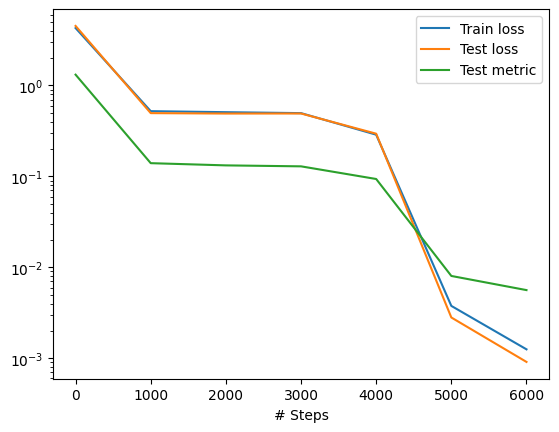

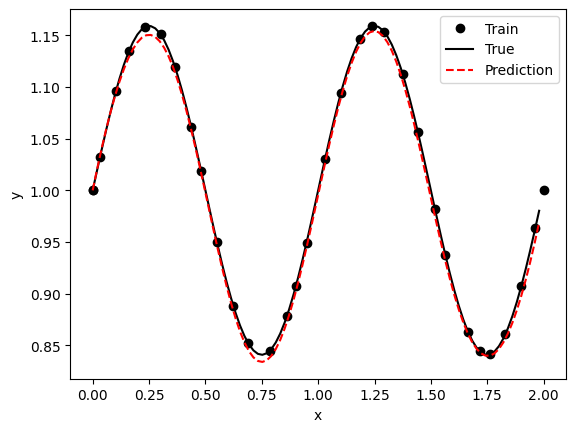

In [12]:
dde.saveplot(model.losshistory, model.train_state, issave = False, isplot = True)

In [13]:
t = geom.uniform_points(100, boundary=True)
u_true = true_solution(t)
u_pred = model.predict(t)
dde.metrics.l2_relative_error(u_true, u_pred)

0.005677011

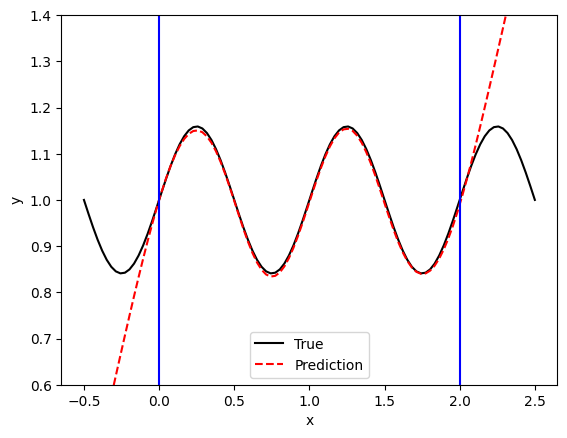

In [14]:
t_test = np.linspace(-0.5, 2.5, 100).reshape(-1, 1)

u_true = true_solution(t_test)
u_pred = model.predict(t_test)

plt.plot(t_test, u_true, 'k', label='True')
plt.plot(t_test, u_pred, 'r--', label='Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(0, color='b')
plt.axvline(2, color='b')
plt.ylim(0.6, 1.4)
plt.legend()